Primeiramente iremos importar todas as bibliotecas necessárias para realizar o nosso treinamento.

In [946]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Importação de funções para pré processamento dos dados
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

# Importação de função para separação dos dados de treino, teste e validação
from sklearn.model_selection import train_test_split

# Importação de alguns algoritmos de treinamento

# KNN
from sklearn.neighbors import KNeighborsClassifier

# Regressão Logística
from sklearn.linear_model import LogisticRegression

# SVM - Support Vector Machine
from sklearn.svm import SVC

# Árvore de Decisão
from sklearn.tree import DecisionTreeClassifier

# Floresta Aleatória
from sklearn.ensemble import RandomForestClassifier

# Importação de algumas métricas de avaliação do nosso modelo
from sklearn.metrics import accuracy_score, classification_report

In [947]:
df = pd.read_csv('fertilizer_prediction.csv', sep=',')
df.head()

,Temperature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,26,52,38,Sandy,Maize,37,0,0,Urea
1,29,52,45,Loamy,Sugarcane,12,0,36,DAP
2,34,65,62,Black,Cotton,7,9,30,14-35-14
3,32,62,34,Red,Tobacco,22,0,20,28-28
4,28,54,46,Clayey,Paddy,35,0,0,Urea


## Limpeza dos dados

In [948]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Temperature      99 non-null     int64 
 1   Humidity         99 non-null     int64 
 2   Moisture         99 non-null     int64 
 3   Soil Type        99 non-null     object
 4   Crop Type        99 non-null     object
 5   Nitrogen         99 non-null     int64 
 6   Potassium        99 non-null     int64 
 7   Phosphorous      99 non-null     int64 
 8   Fertilizer Name  99 non-null     object
dtypes: int64(6), object(3)
memory usage: 7.1+ KB


In [949]:
# Caso houver dados duplicados, remove-os

if df.duplicated().sum() > 0:
    df.drop_duplicates(inplace=True)

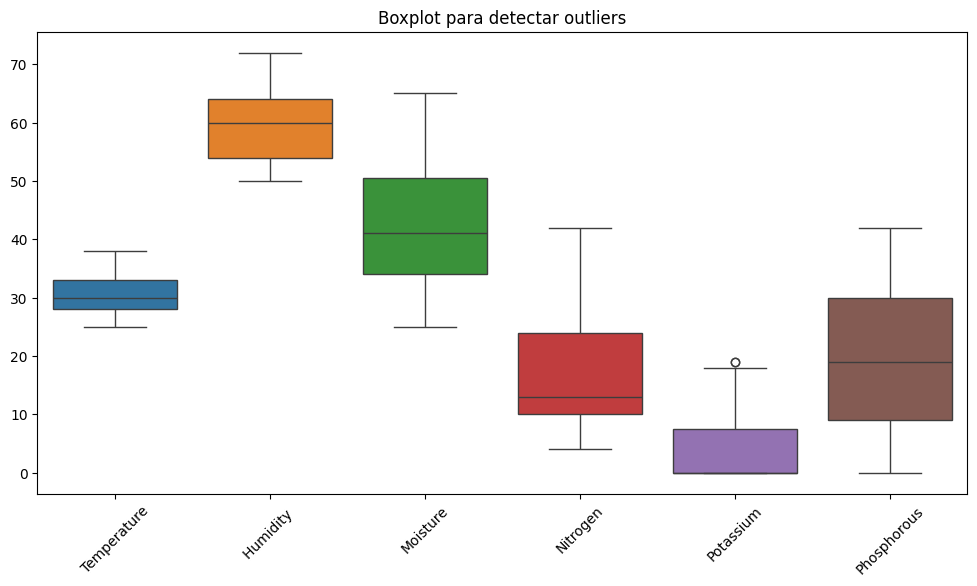

In [950]:
# Verificar a presença de Outliers no dataset

plt.figure(figsize=(12,6)) # Aumenta o gráfico
sns.boxplot(data=df)
plt.title('Boxplot para detectar outliers')
plt.xticks(rotation=45)# Rotaciona os labels em 45°
plt.show()

# É possível observar que temos um outlier em "Potassium", pois há uma bolinha acima do intervalo

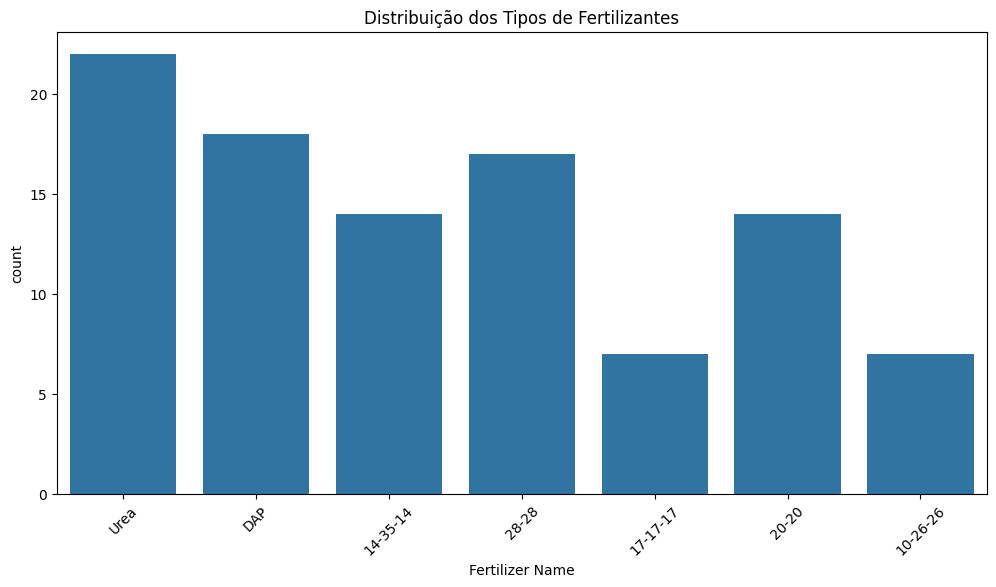

In [951]:
# Exploração da distribuição dos labels (no caso, do nome do fertilizante)

plt.figure(figsize=(12,6))
sns.countplot(x='Fertilizer Name', data=df) # Esta função irá contar os labels da coluna 'Fertilizer Name'
plt.title("Distribuição dos Tipos de Fertilizantes")
plt.xticks(rotation=45)
plt.show()

Temos 7 (sete) classes possíveis, portanto, é um problema de **Classificação multiclasse**.

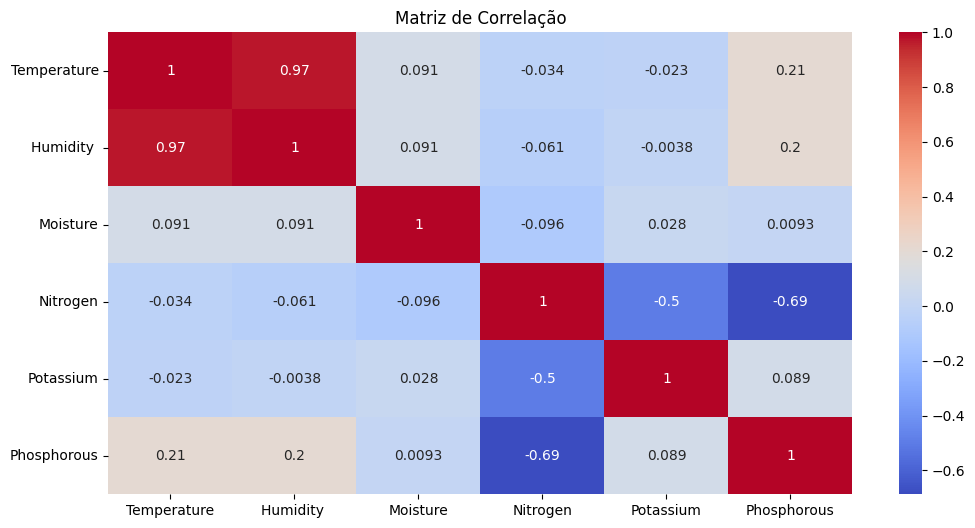

In [952]:
# Investigação da correlação entre as variáveis

# Se duas ou mais colunas estão altamente correlacionadas, pode ser interessante remover alguma delas
# para facilitar a convergência do algoritmo preditivo

plt.figure(figsize=(12,6))
sns.heatmap(df.select_dtypes(include=['int64']).corr(), annot=True, cmap='coolwarm')
plt.title("Matriz de Correlação")
plt.show()

É possível observar que as variáveis "temperatura e umidade" e "fósforo e nitrogênio" estão fortemente relacionadas, porém no momento não vamos nos preocupar com isso.

Iremos trabalhar com todas as variáveis sendo features para o modelo preditivo.

## Engenharia de Features

Aqui realizaremos as seguintes ações:
- Separamos as features X do label y
- Criamos uma codificação para os dados em string, representando-os em números via LabelEncoder (para dados ordinais ou labels) ou OneHotEncoder (para dados nominais)
- Removemos as colunas originais antes dos tratamentos
- Separamos os dados em treino (80%) e teste (20%)
- Normalizamos as features numéricas, sempre "aprendendo" a fórmula no treino e a aplicando no treino e no teste.

In [953]:
# Separando as features sem os labels (X são as variáveis independentes)
X = df.drop('Fertilizer Name', axis=1) # axis=1 remove a coluna inteira

# Separando os labels (y são as variáveis dependentes esperadas)
y = df['Fertilizer Name']
y.head()

0        Urea
1         DAP
2    14-35-14
3       28-28
4        Urea
Name: Fertilizer Name, dtype: object

**Resumindo:**

**X** são todos os dados de entrada (variáveis independentes)

**y** é a variável dependente esperada, ou seja, quando formos realizar o teste, é necessário verificarmos se a predição da IA corresponde às labels esperadas

Esta ML irá prever qual é o nome do fertilizante baseado na umidade do solo, temperatura, potassio, etc...

In [954]:
# Pré-processamento dos dados

# Label Encoder para a variável alvo (Fertilizer Name)
le = LabelEncoder()

# Aqui todas as strings viraram números, então a coluna, antes um array de string, agora virou um array de numeros
y = le.fit_transform(y)
print("Labels: ", y) 

print("Labels únicas:", len(pd.unique(y)))

Labels:  [6 5 1 4 6 2 3 6 4 1 5 2 6 4 5 2 6 4 6 5 3 2 5 6 3 4 1 6 5 3 4 5 6 1 4 6 1
 5 2 5 3 1 4 6 5 1 3 4 6 1 4 3 6 5 2 4 6 3 2 5 6 3 4 0 6 5 3 1 0 3 4 6 4 6
 5 1 4 3 0 5 1 6 5 3 4 1 0 6 0 5 1 0 6 1 4 0 6 5 3]
Labels únicas: 7


In [955]:
# Colunas categóricas:
categorical_cols = ['Soil Type', 'Crop Type']

# handle_unknown: Caso não encontre uma categoria, não dará erro
ohe = OneHotEncoder(handle_unknown='ignore')

# Transformando os dados categóricos em colunas
# Nesta linha, ele vai transformar todos os dados categóricos em colunas
X_encoded = pd.DataFrame(ohe.fit_transform(X[categorical_cols]).toarray()) # É necessário converter para array antes de transforma-lo em um DataFrame do Pandas
X_encoded = X_encoded.add_prefix('OHE_')
X_encoded.head()

# Primeiro é criado as 5 categorias de Soil Type (OHE_0, 1, 2, 3 e 4)
# Em seguida cria as demais categorias de Crop Type (OHE_5 até OHE_15)

,OHE_0,OHE_1,OHE_2,OHE_3,OHE_4,OHE_5,OHE_6,OHE_7,OHE_8,OHE_9,OHE_10,OHE_11,OHE_12,OHE_13,OHE_14,OHE_15
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [956]:
# Remove as colunas categóricas originais
X = X.drop(categorical_cols, axis=1)

# Concatena as features codificadas (após o pré processamento) com as numéricas
X = pd.concat([X, X_encoded], axis=1) # axis=1 significa que iremos concatenar colunas
X.head()

,Temperature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous,OHE_0,OHE_1,OHE_2,OHE_3,OHE_4,OHE_5,OHE_6,OHE_7,OHE_8,OHE_9,OHE_10,OHE_11,OHE_12,OHE_13,OHE_14,OHE_15
0,26,52,38,37,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,29,52,45,12,0,36,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,34,65,62,7,9,30,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,32,62,34,22,0,20,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,28,54,46,35,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Divisão dos dados em conjuntos de treino (80%) e testes (20%)

In [957]:
# 1° Parametro: variáveis independentes (dados de entrada)
# 2° Parametro: variáveis dependentes (valores esperados, rótulos)
# 3° Parametro: test_size especifica a proporção do conjunto de dados que será usada para o conjunto de teste, no caso, 0.2 (20%)
# 4° Parametro: random_state é uma semente (seed) que determina como os dados são misturados antes de serem divididos.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**random_state:**

Usar o mesmo valor (por exemplo, 42) significa que sempre terá a mesma divisão dos dados quando executar o código novamente. Isso é útil para tornar os resultados reprodutíveis.

Caso o random_state não for definido, toda vez que executar o código, a divisão dos dados pode mudar, resultando em diferentes conjuntos de treinamento e teste. 

Isto pode fazer com que fique dificil a comparação de resultados entre diferentes execuções, pois a performance do modelo pode variar apenas por causa de como os dados foram divididos.

In [958]:
# Normalização das features numéricas

scaler = MinMaxScaler()

# Normalização dos dados de treino
# O fit calcula a média e o desvio padrão de cada feature
# O transform transforma os dados de acordo com essa média e desvio padrão, normalizando-os para que tenham média 0 e desvio padrão 1
X_train_scaled = scaler.fit_transform(X_train)

# Normalização dos dados de teste
# Aqui apenas utilizando transform, o MinMaxScaler não recalcula as estatísticas (média e desvio padrão)
# "Pega" os dados do conjunto de teste e os ajusta com as mesmas escalas que foram aplicadas no conjunto de treino
X_test_scaled = scaler.transform(X_test)

- Use *fit-transform* quando desejar calcular as estatísticas (média e desvio padrão) a partir dos dados, e ao mesmo tempo, transformar esses dados **(geralmente no conjunto de treinamento)**

- Use *transform* para transformar os novos dados **(como o conjunto de testes)** usando as estatísticas calculadas previamente durante o fit no conjunto de treinamento.

Isso garante que o modelo não tenha acesso a dados de teste durante seu treinamento, o que é fundamental para uma avalidação justa do desempenho do modelo.

## Construindo os modelos preditivos

### Regressão logística

In [959]:
logReg = LogisticRegression()

# 1° Parametro: dados de teste normalizados
# 2° Parametro: rótulos esperados
# Fit treina o modelo com os dados de treino
logReg.fit(X_train_scaled, y_train)

# Realiza a predição dos valores com a base de dados de teste
y_predict_logReg = logReg.predict(X_test_scaled)

# Realiza a métrica de desempenho do modelo baseado na Acurácia

# 1° Parametro: Rótulos esperados
# 2° Parametro: Rótulos previstos pelo modelo
print('Acurácia Regressão Logística:', accuracy_score(y_test, y_predict_logReg) * 100)
print(classification_report(y_test, y_predict_logReg))

Acurácia Regressão Logística: 70.0
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.60      0.60      0.60         5
           5       0.57      0.80      0.67         5
           6       1.00      1.00      1.00         6

    accuracy                           0.70        20
   macro avg       0.53      0.48      0.49        20
weighted avg       0.69      0.70      0.68        20



c:\Users\DIOGO-PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DIOGO-PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DIOGO-PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

### KNN

In [960]:
knn = KNeighborsClassifier(n_neighbors=9) # O parametro significa que irá pegar 9 vizinhos

# Realiza o treinamento
knn.fit(X_train_scaled, y_train)

# Realiza o teste
y_predict_knn = knn.predict(X_test_scaled)

print("Acurácia KNN:", accuracy_score(y_test, y_predict_knn) * 100)

Acurácia KNN: 30.0


### SVM (Support Vector Machine)

In [961]:
# Utilizando o kernel RBF -> mais complexo
svm = SVC(kernel='rbf')

svm.fit(X_train_scaled, y_train)

y_predict_svm_rbf = svm.predict(X_test_scaled)

print("Acurácia SVM (RBF):", accuracy_score(y_test, y_predict_svm_rbf) * 100)

Acurácia SVM (RBF): 35.0


In [962]:
# Utilizando o kernel polinomial -> mais intermediário
svm = SVC(kernel='poly')

svm.fit(X_train_scaled, y_train)

y_predict_svm_poly = svm.predict(X_test_scaled)

print("Acurácia SVM (Polinomial):", accuracy_score(y_test, y_predict_svm_poly) * 100)

Acurácia SVM (Polinomial): 45.0


In [963]:
# Utilizando o kernel linear -> mais simples
svm = SVC(kernel='linear')

svm.fit(X_train_scaled, y_train)

y_predict_svm_linear = svm.predict(X_test_scaled)

print("Acurácia SVM (Linear):", accuracy_score(y_test, y_predict_svm_linear) * 100)

Acurácia SVM (Linear): 85.0


### Árvore de Decisão

In [964]:
decision_tree = DecisionTreeClassifier()

# Realiza o treinamento
decision_tree.fit(X_train_scaled, y_train)

# Realiza o teste
y_predict_decision_tree = decision_tree.predict(X_test_scaled)

print("Acurácia KNN:", accuracy_score(y_test, y_predict_decision_tree) * 100)

Acurácia KNN: 100.0


### Floresta Randômica (Aleatória)

In [965]:
# n_estimators define o número de árvores (estimadores) que serão criadas e utilizadas na floresta
random_forest = RandomForestClassifier(n_estimators=25)

random_forest.fit(X_train_scaled, y_train)

y_predict_random_forest = random_forest.predict(X_test_scaled)

print("Acurácia KNN:", accuracy_score(y_test, y_predict_random_forest) * 100)

Acurácia KNN: 95.0
